## Librerias

In [2]:
import pandas as pd
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pd.set_option('display.float_format', '{:.3f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

## Clustering

### Preparación de los datos

In [14]:
#DATA FISLAC
dff = pd.read_csv("INPUT/FISLAC_update.csv")

#POBLACIÓN
pob = pd.read_excel("INPUT/POP_WB.xlsx")
pob['DATE'] = pd.to_datetime(pob['DATE'], format='%Y')
pob['POP'] = pd.to_numeric(pob['POP'], errors='coerce')
pob.sort_values(by=['ISO3', 'DATE'], inplace=True)

# pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate())
# pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate().fillna(method='bfill').fillna(method='ffill'))

pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate()).reset_index(level=0, drop=True)
pob['POP'] = pob.groupby('ISO3')['POP'].apply(lambda x: x.interpolate().bfill().ffill()).reset_index(level=0, drop=True)

pob['DATE'] = pob['DATE'].dt.year


# VARIABLES
variables = ["DEBT_GDP", "EXP_GDP", "REV_GDP","INTR_EXPENSES_GDP", "DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "CURR_EXP_GDP",
             "WGI_CONTR_CORR", "WGI_GOV_EFFECT", "WGI_POL_STAB", "WGI_REG_QUAL", "WGI_ROL", "WGI_VOICE_ACCOUNT",
             "TRADE_OPEN", "NET_FDI_GDP", "BROAD_MONEY_GDP", "INTRES_GDP",  "INFLATION",
             "LUR", "CAP_RETURN", "INT_RESERVES_CAP","BANK_CRISIS", "COMDEP",
             "CONSUMPTION_PC" ]

fr = ["FISCAL_RULE"]
ids = ["COUNTRY_NAME", "WEO_CODE", "ISO3" , "LAC1", "LAC2", "GROUP", "REGION", "DATE"]


#FILTRAR POR REGLAS FISCALES
df = dff[ids + variables + fr]

fr = df[["ISO3", "DATE", "FISCAL_RULE"]]
fr = fr[df.DATE>2000]
fr = fr.groupby(["ISO3"])["FISCAL_RULE"].sum().reset_index()
fr["FISCAL_RULE"] = fr["FISCAL_RULE"].apply(lambda x: 1 if x>0 else 0)

df = df[ids + variables]

df = df.merge(fr, "left", "ISO3")
df= df[df.FISCAL_RULE==1]

df = df[ids + variables]

df = df.merge(pob, "left", ["DATE", "ISO3"])
grupos = df[["ISO3", "REGION", "GROUP", "COUNTRY_NAME"]].drop_duplicates()

### Parametros (paises tratados etc)

In [34]:
año_inferior = 2000
año_superior = 2005

# tratado = "PER"
tratado = "MEX"
# tratado = "GBR"

dfc = df[(df.DATE>=año_inferior) & (df.DATE<=año_superior)]
# dfc = dfc.groupby("ISO3").mean()

dfc = dfc.groupby(["ISO3"])[variables].mean()

# dfc = dfc[variables]

dfcm = dfc.copy()
dfcm = dfcm.merge(grupos, "left", "ISO3")

dfc = pd.DataFrame(scaler.fit_transform(dfc), columns=dfc.columns, index = dfc.index)


treated = dfcm[dfcm.ISO3 == tratado].T.reset_index()
treated.columns = ["VARIABLE", "MEDIA"]
maximo_mimebros = 20

In [35]:
os.makedirs(f'OUTPUT_{tratado}', exist_ok=True)

In [36]:
os.makedirs(f'OUTPUT_{tratado}/CLUSTERING', exist_ok=True)

### PCA

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principal_components = pca.fit_transform(dfc)
df_principal = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3'], index = dfc.index)

In [38]:
def plot_clusters(df_principal, save):
    fig, ax = plt.subplots(figsize=(10, 8))
    if tratado == "PER":
        special_colors = {'PER': 'red', 'MEX': 'green', 'GBR': 'blue'}
    
    if tratado == "MEX":
        special_colors = {'MEX': 'green', 'PER': 'red', 'GBR': 'blue'}

    if tratado == "GBR":
        special_colors = {'GBR': 'blue', 'MEX': 'green', 'PER': 'red'}

    color_map = {}
    used_colors = ['gray']*25

    color_iter = iter(used_colors)
    for cluster in df_principal['Cluster'].unique():
        found_special = False
        for special_index in special_colors:
            if special_index in df_principal[df_principal['Cluster'] == cluster].index:
                color_map[cluster] = special_colors[special_index]
                found_special = True
                break
        if not found_special:
            color_map[cluster] = next(color_iter)

    # Actualizar el DataFrame con los colores asignados
    df_principal['color'] = df_principal['Cluster'].map(color_map)

    # Dibujar texto y círculos para resaltar índices especiales
    for idx, row in df_principal.iterrows():
        ax.text(row['PC1'], row['PC2'], idx, color=row['color'], ha='center', va='center')
        if idx in special_colors:
            circle = Circle((row['PC1'], row['PC2']), 0.3, color=row['color'], fill=False, linewidth=2)
            ax.add_patch(circle)

    ax.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    ax.axvline(0, color='gray', linestyle='dashed', linewidth=1)

    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    plt.savefig(save, dpi = 300, bbox_inches='tight')

    plt.show()

### Clustering jerárquico aglomerativo

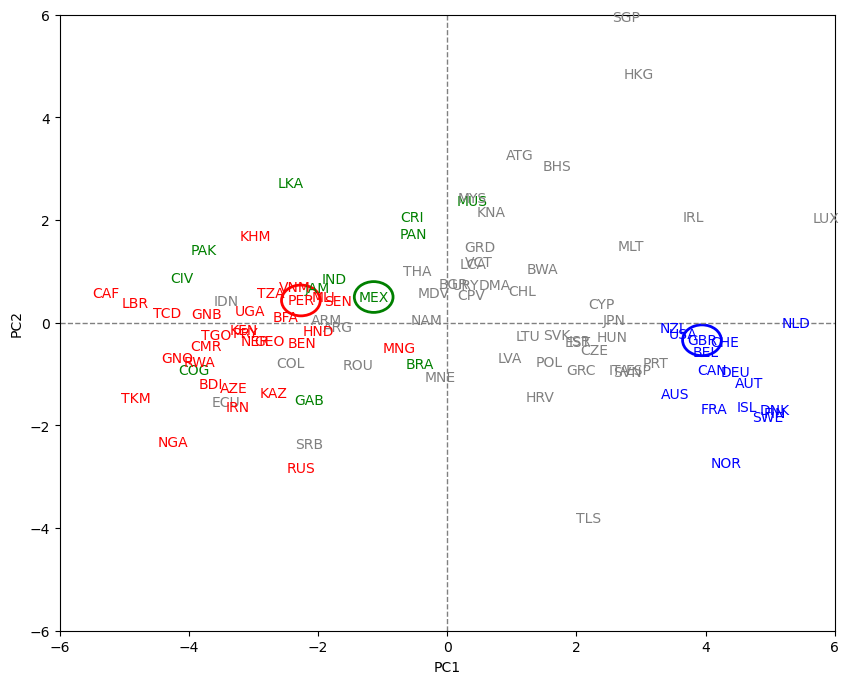

In [42]:
linked = linkage(dfc, method='ward')

from scipy.cluster.hierarchy import fcluster

for i in range(1,25):
    num_clusters = i
    clusters = fcluster(linked, num_clusters, criterion='maxclust')
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]==tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break

# dfcm = dfcm.select_dtypes(include=['number'])
jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()
jerarquico_media.columns = ["VARIABLE", "JERARQUICO"]

# jerarquico_media = dfcm[dfcm.cluster == cluster_peru].mean().reset_index(); 
jerarquico_media.loc[-1] = ["N", miembros]
treated = treated.merge(jerarquico_media, "outer", "VARIABLE")

jerarquico_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)
df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/0JERARQUICO.jpg')

### Clustering espectral

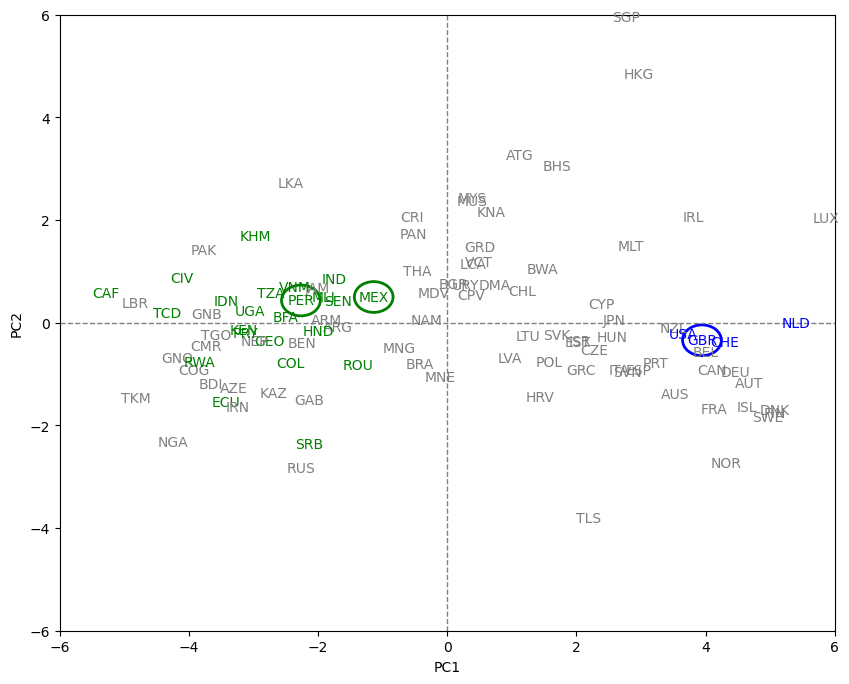

In [45]:
from sklearn.cluster import SpectralClustering

for i in range(5,25):

    num_clusters = i
    spectral = SpectralClustering(n_clusters= num_clusters, assign_labels='discretize',random_state=0).fit(dfc.values)
    clusters = spectral.fit_predict(dfc.values)
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]==tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


espectral_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()

jerarquico_media.columns = ["VARIABLE", "ESPECTRAL"]

jerarquico_media.loc[-1] = ["N", miembros]
treated = treated.merge(jerarquico_media, "outer", "VARIABLE")

df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/1ESPECTRAL.jpg')

### Clustering BIRCH

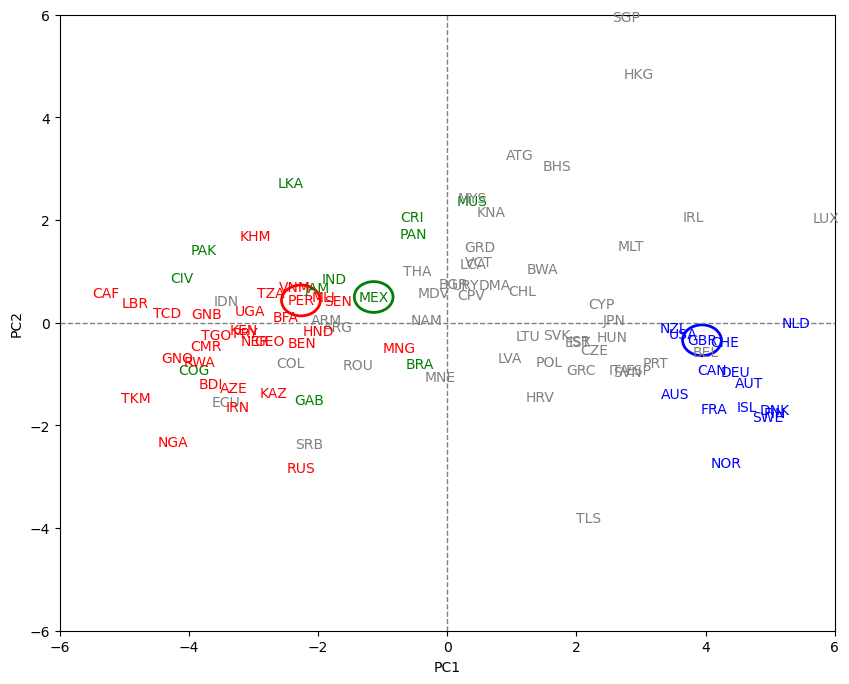

In [46]:
from sklearn.cluster import Birch


for i in range(1,25):

    birch = Birch(n_clusters=i)
    clusters = birch.fit_predict(dfc)
    clusters
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"]==tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros<=maximo_mimebros:
        break


birch_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()

jerarquico_media.columns = ["VARIABLE", "BIRCH"]
jerarquico_media.loc[-1] = ["N", miembros]
treated = treated.merge(jerarquico_media, "outer", "VARIABLE")

df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/2BIRCH.jpg')

### Clustering Kmeans

c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak o

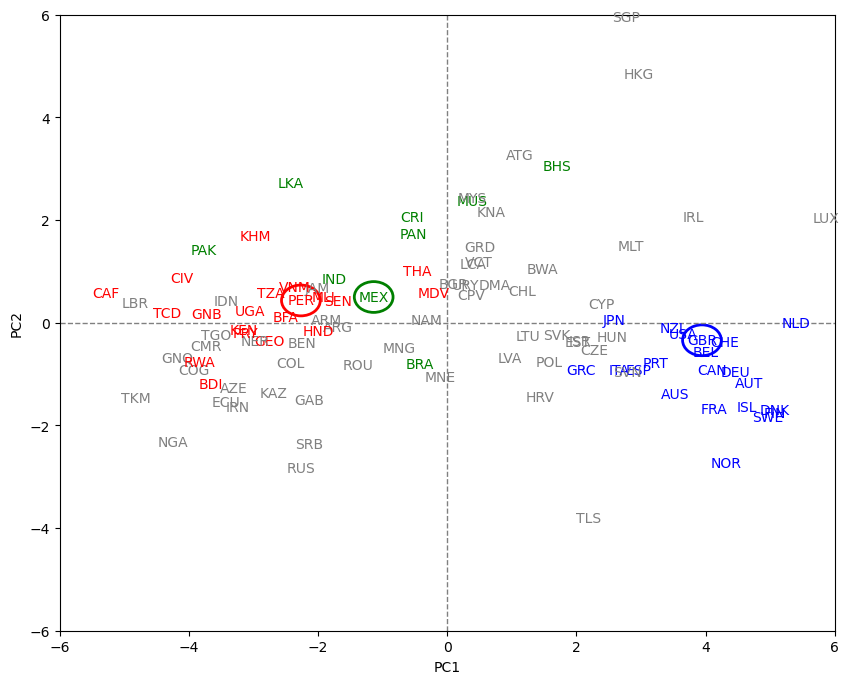

In [47]:
from sklearn.cluster import KMeans

# Suponemos que dfc es tu DataFrame y dfcm es otro DataFrame que incluye la columna 'ISO3'
maximo_miembros = 10  # Ajusta esto según el máximo de miembros deseado por cluster

for i in range(1, 25):
    num_clusters = i
    # Inicializar y ajustar KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(dfc)
    clusters = kmeans.labels_  # Obtener las etiquetas de los clusters directamente
    dfcm["cluster"] = clusters
    cluster_peru = dfcm[dfcm["ISO3"] == tratado].cluster.values[0]
    miembros = dfcm[dfcm.cluster == cluster_peru].shape[0]

    if miembros <= maximo_miembros:
        break

# Lista de códigos ISO3 de los miembros del cluster encontrado
kmean_lista = list(dfcm[dfcm.cluster == cluster_peru].ISO3)

# Calcular las medias para el cluster de interés
jerarquico_media = dfcm[dfcm.cluster == cluster_peru].select_dtypes(include=['number']).mean().reset_index()
jerarquico_media.columns = ["VARIABLE", "KMEANS"]
jerarquico_media.loc[-1] = ["N", miembros]  # Agregar el número de miembros al DataFrame
jerarquico_media = jerarquico_media.sort_index().reset_index(drop=True)

# Integrar estos resultados en otro DataFrame si es necesario
treated = treated.merge(jerarquico_media, on="VARIABLE", how="outer")
df_principal["Cluster"] = clusters
plot_clusters(df_principal, f'OUTPUT_{tratado}/CLUSTERING/3KMEANS.jpg')


### Descriptivas

In [48]:
final_descr = treated.iloc[list(range(1,25))+[-1]]; final_descr = final_descr.rename(columns = {"MEDIA": tratado})
final_descr["MEDIA CLUSTERS"] = final_descr.iloc[:, 2:].T.mean()
final_descr = final_descr[['VARIABLE', tratado, 'MEDIA CLUSTERS', 'JERARQUICO', 'ESPECTRAL', 'BIRCH', 'KMEANS']]
final_descr.to_excel(f'OUTPUT_{tratado}/CLUSTERING/descriptive.xlsx')
final_descr

,VARIABLE,MEX,MEDIA CLUSTERS,JERARQUICO,ESPECTRAL,BIRCH,KMEANS
1,BROAD_MONEY_GDP,0.257,0.470,0.445,0.261,0.445,0.783
2,CAP_RETURN,0.126,0.149,0.147,0.123,0.147,0.181
3,COMDEP,0.128,0.256,0.288,0.302,0.288,0.081
4,CONSUMPTION_PC,12160.467,6262.968,6170.203,3517.157,6170.203,9379.842
5,COUNTRY_NAME,Mexico,NaN,NaN,NaN,NaN,NaN
6,CURR_EXP_GDP,0.148,0.146,0.150,0.126,0.150,0.153
7,DEBT_AFFORTABILITY,0.166,0.224,0.254,0.094,0.254,0.234
8,DEBT_GDP,0.408,0.679,0.740,0.536,0.740,0.582
9,EXP_GDP,0.213,0.225,0.233,0.202,0.233,0.221
10,GROUP,EMDEs,NaN,NaN,NaN,NaN,NaN


### Descriptivas: paises

In [52]:
lista_total = jerarquico_lista+espectral_lista+birch_lista+kmean_lista
cfrq = pd.DataFrame(index=pd.Series(lista_total).unique())

# Agregar las columnas para cada método y llenar con 0 o 1
cfrq['Jerarquico'] = [1 if x in jerarquico_lista else 0 for x in cfrq.index]
cfrq['Espectral'] = [1 if x in espectral_lista else 0 for x in cfrq.index]
cfrq['Birch'] = [1 if x in birch_lista else 0 for x in cfrq.index]
cfrq['KMeans'] = [1 if x in kmean_lista else 0 for x in cfrq.index]
cfrq["Total"] = cfrq.T.sum()
cfrq = cfrq.sort_values("Total", ascending = False)
cfrq = cfrq.reset_index(); cfrq = cfrq.rename(columns = {"index": "ISO3"})
paises = dff[["ISO3", "COUNTRY_NAME"]].drop_duplicates()
cfrq = cfrq.merge(paises, "left", "ISO3")
cfrq = cfrq[cfrq.ISO3!=tratado]

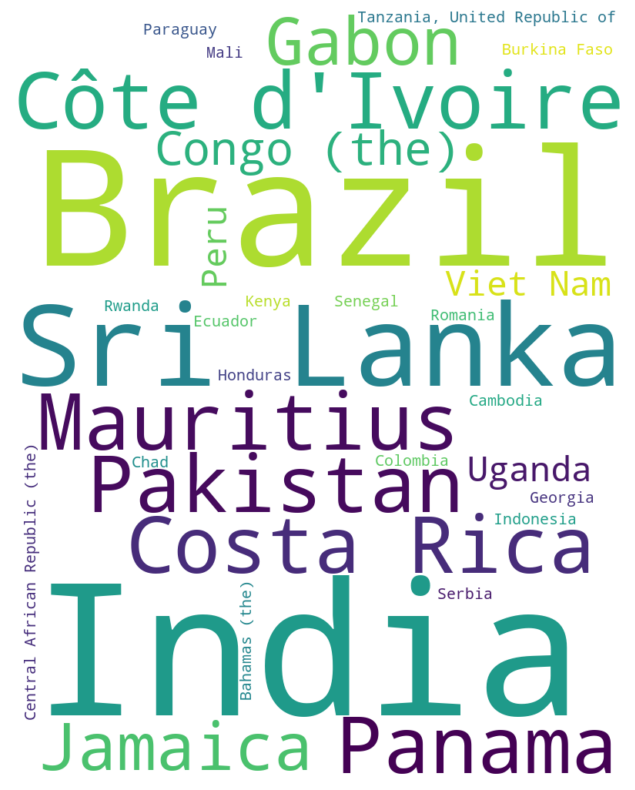

In [53]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=1000, background_color='white').generate_from_frequencies(dict(zip(cfrq['COUNTRY_NAME'], cfrq['Total'])))

# Mostrar la nube de palabras
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig(f'OUTPUT_{tratado}/CLUSTERING/WORDCLOUD.jpg', dpi = 300, bbox_inches='tight')
plt.show()


In [54]:
clusterdf = cfrq[["ISO3", "Total"]]; clusterdf.columns = ["ISO3", "CLUSTER"]
df = df.merge(clusterdf, "left", "ISO3")
df["CLUSTER"] = df["CLUSTER"].fillna(0)

In [55]:
df.to_csv(f"{tratado}_DB.csv", index = False)

# Run synthetic control

In [210]:
tratado = "GBR"
pais = "GBR"

In [211]:
df = pd.read_csv(f"{tratado}_DB.csv")

## Parametros

In [403]:
# Load Data 
# --------------------------------------------------------------------------
# tratado = "GBR"
# pais = "GBR"

# muestra = "EUR"
# muestra  = "CLU"
# muestra = "CLU&EUR"


# tratado = "MEX"
# pais = "MEX"

tratado = "PER"
pais = "PER"

# muestra = "LAC"
muestra  = "CLU"
# muestra = "CLU&LAC"


# --------------------------------------------------------------------------

# year_t0 = 1995 #AÑO AL INICIO

year_t0 = 2000 #AÑO AL INICIO
year_t1 = 2010 #AÑO DEL TRATAMIENTO
year_t2 = 2018 #AÑO FINAL

df = pd.read_csv(f"{tratado}_DB.csv")

d = df[df.DATE<=year_t2]
d = d[d.DATE>=year_t0]

code_treated = d[d.ISO3==pais]["WEO_CODE"].iloc[0]

# --------------------------------------------------------------------------
if pais == "PER":

    if muestra == "LAC":
        d = d[d['LAC1'] == 1]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 2) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&LAC":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated)) | ((d['LAC1'] == 1) | (d['WEO_CODE'] == code_treated))]

# --------------------------------------------------------------------------     

if (pais == "MEX") | (pais == "PAN"):

    if muestra == "LAC":
        d = d[d['LAC1'] == 1]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&LAC":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated)) | ((d['LAC1'] == 1) | (d['WEO_CODE'] == code_treated))]

# --------------------------------------------------------------------------

# paises_uk = [pais, "USA", "AUS", "GEO", "IRL", "NLD", "GEO"]
# d = d[d['ISO3'].isin(paises_uk)]

if tratado == "GBR":

    region = df[df.ISO3=="GBR"].REGION.iloc[0]

    if muestra == "EUR":
        d = d[d['REGION'] == region]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&EUR":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated)) | ((d['REGION'] == region) | (d['WEO_CODE'] == code_treated))]

os.makedirs(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}', exist_ok=True) 

In [404]:
#################################################################################
# PARAMETERS
#################################################################################

# predictors_dp       = ["DEBT_GDP"]
predictors_dp       = ["DEBT_GDP","EXP_GDP", "INTRES_GDP"]
dependent_dp        = "DEBT_GDP"
id_variable         = "WEO_CODE"
time_variable       = "DATE"

special_predictors = None

special_predictors  = [("REV_GDP", range(year_t0,year_t1), "mean"),
                           ("TRADE_OPEN", range(year_t0,year_t1), "mean"),
                            ("NET_FDI_GDP", range(year_t0,year_t1), "mean"),
                            ("LUR", range(year_t0,year_t1), "mean"),
                            ("CAP_RETURN", range(year_t0,year_t1), "mean"),
                            ("INFLATION", range(year_t0,year_t1), "mean")]



treated             = code_treated 
controls            = list(set(d['WEO_CODE'].unique()) - set([treated]))
time_predictors     = range(year_t0,year_t1)
time_ssr            = range(year_t0,year_t1)

#################################################################################
# DATA PREPARATION
#################################################################################


dataprep = Dataprep(
           foo = d,
           predictors    = predictors_dp,
           predictors_op="mean",
           dependent     = dependent_dp,
           unit_variable = id_variable,
           time_variable = time_variable,
           special_predictors = special_predictors,
           treatment_identifier = treated,
           controls_identifier = controls,
           time_predictors_prior = time_predictors,
           time_optimize_ssr = time_ssr)

# #################################################################################
# print(dataprep)
# #################################################################################
# A = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "trust-constr"]
# A = ["Powell", "COBYLA"]
# resultados = {}

# for metodo in A:
#     synth = Synth()
#     synth.fit(dataprep=dataprep, optim_method=metodo, optim_initial="ols")
#     print(metodo)
#     synth.path_plot(time_period=range(year_t0, year_t2), treatment_time=year_t1)
#     mae = synth.mae()
#     mse = synth.mspe()
#     resultados[metodo] = {'MAE': mae, 'MSE': mse}

# metodo_optimo = min(resultados, key=lambda x: resultados[x]['MSE'])
# synth.fit(dataprep=dataprep, optim_method=metodo_optimo, optim_initial="ols")

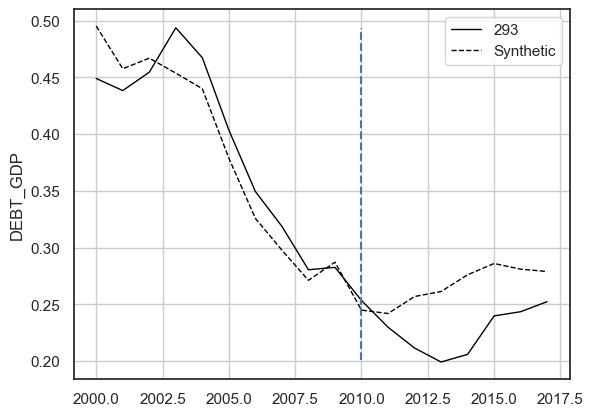

In [405]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="COBYLA", optim_initial="ols")
synth.path_plot(time_period=range(year_t0, year_t2), treatment_time=year_t1)

## Variables

In [406]:
# Crear un objeto ExcelWriter
tablas = pd.ExcelWriter(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/Tablas.xlsx')

In [407]:
variables = synth.summary().round(3)
variables.columns = ["Weight", pais, f"{pais} Synth", "Sample Mean"]
variables.to_excel(tablas, sheet_name='Variables')
variables

,Weight,PER,PER Synth,Sample Mean
DEBT_GDP,0.453,0.394,0.387,0.583
EXP_GDP,0.253,0.201,0.203,0.199
INTRES_GDP,0.252,0.209,0.206,0.116
special.1.REV_GDP,0.006,0.199,0.189,0.192
special.2.TRADE_OPEN,0.002,0.440,0.927,0.617
special.3.NET_FDI_GDP,0.031,-0.222,-0.251,-0.213
special.4.LUR,0.002,0.089,0.039,0.056
special.5.CAP_RETURN,0.000,0.174,0.099,0.105
special.6.INFLATION,0.001,0.026,0.079,0.067


## Countries

In [408]:
# UK
# Country	Weight
# 33	Australia	0.433
# 45	United States of America (the)	0.325
# 4	Netherlands (the)	0.23

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_53604\3723473148.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_yticklabels(labels=filtered_countries['Country'], fontsize=10)


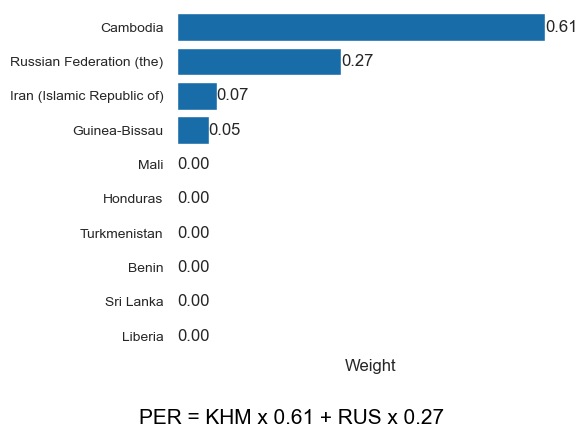

In [409]:
countries = d[["ISO3", "WEO_CODE", "COUNTRY_NAME"]].drop_duplicates()
countriesw = pd.DataFrame(zip(controls,synth.W)); countriesw.columns = ["WEO_CODE", "Weight"]
countries = countries.merge(countriesw, "right", "WEO_CODE")
countries = countries[["ISO3", "COUNTRY_NAME", "Weight"]]
countries.columns = ["ISO3", "Country", "Weight"]
countries = countries.sort_values(by = "Weight", ascending=False)
countries.to_excel(tablas, sheet_name='Donors Countries')

filtered_countriesq = countries[countries['Weight'] > 0.1]
filtered_countries = countries.iloc[0:10]

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='Weight', y='Country', data=filtered_countries, color='#0070C0')
barplot.set_yticklabels(labels=filtered_countries['Country'], fontsize=10)
barplot.bar_label(barplot.containers[0], fmt='%.2f')
plt.xticks([])
plt.ylabel("")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
equation_parts = [f"{row['ISO3']} x {row['Weight']:.2f}" for index, row in filtered_countriesq.iterrows()]
equation_text = f"{tratado} = " + " + ".join(equation_parts)
plt.figtext(0.5, -0.08, equation_text, wrap=True, horizontalalignment='center', fontsize=15, color='black')
plt.tight_layout()
plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/0COUNTRIES.jpg', dpi = 300, bbox_inches='tight')
plt.show()

In [411]:
len(countries)

34

## Effects

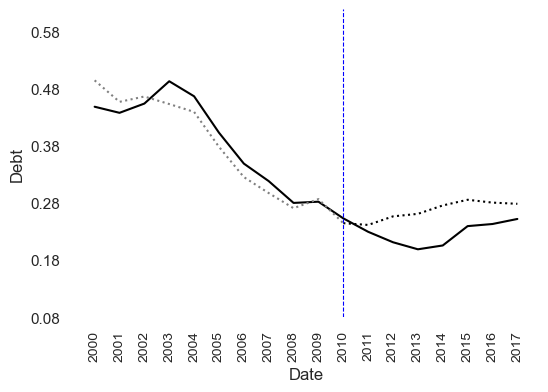

In [412]:
Z0, Z1   = dataprep.make_outcome_mats(time_period=range(year_t0, year_t2))
y_synth  = (Z0 * synth.W).sum(axis = 1)
y_actual = Z1
y_sample = Z0.T.mean()
effect    = y_actual - y_synth 
treat_year = fila = np.where(np.arange(year_t0, year_t2 + 1) == year_t1, 1, 0)
efecto = pd.DataFrame(zip(y_sample, y_actual, y_synth, effect, treat_year),
                      columns = ["Sample Mean", pais,f"{pais} Synth", "Effect", "Tyear"])
efecto.index = y_sample.index; efecto = efecto.reset_index(drop = False)
efecto.to_excel(tablas, sheet_name='Efecto')

# efecto = efecto[efecto.DATE>=2000]

plt.figure(figsize=(6, 4))
sns.set(style="white")
sns.lineplot(data=efecto, x='DATE', y=pais, color='black', label=None)
sns.lineplot(data=efecto[efecto['DATE'] <= year_t1], x='DATE', y=f'{pais} Synth',
             linestyle='dotted', color='gray', label=None)
sns.lineplot(data=efecto[efecto['DATE'] >= year_t1], x='DATE', y=f'{pais} Synth',
             linestyle='dotted', color='black', label=None)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

stdp = (efecto[pais].std()*1.2)
minp = round(efecto[pais].min() - stdp, 2)
# minp = 0
maxp = round(efecto[pais].max() + stdp, 2)
plt.ylim(minp,maxp)
plt.yticks(np.arange(minp,maxp, 0.10))

plt.xlabel('Date')
plt.ylabel("Debt")
plt.axvline(x=year_t1, color='blue', linestyle='dashed', linewidth=0.8)
plt.xticks(efecto['DATE'], rotation=90, fontsize=10)

plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/1SYNTH.jpg', dpi = 300, bbox_inches='tight')

plt.show()

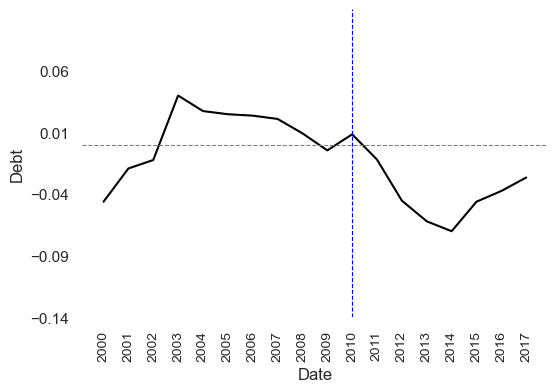

In [413]:
plt.figure(figsize=(6, 4))
sns.set(style="white")
sns.lineplot(data=efecto, x='DATE', y="Effect", color='black', label=None)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

stdp = (efecto["Effect"].std()*2)
minp = round(efecto["Effect"].min() - stdp,2)
maxp = round(efecto["Effect"].max() + stdp,2)

plt.ylim(minp,maxp)
plt.yticks(np.arange(minp,maxp, 0.05))

plt.xlabel('Date')
plt.ylabel("Debt")
plt.axvline(x=year_t1, color='blue', linestyle='dashed', linewidth=0.8)
plt.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.8)

plt.xticks(efecto['DATE'], rotation=90, fontsize=10)

plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}/2EFFECT.jpg', dpi = 300, bbox_inches='tight')

plt.show()

## Placebo

In [414]:
countries = d[["ISO3", "WEO_CODE", "COUNTRY_NAME"]].drop_duplicates()
countriesw = pd.DataFrame(zip(controls,synth.W)); countriesw.columns = ["WEO_CODE", "Weight"]
countries = countries.merge(countriesw, "right", "WEO_CODE")
placebos = dict(zip(countries.WEO_CODE, countries.ISO3))
placebos[code_treated] = pais

In [415]:
from tqdm import tqdm as tq

In [331]:
placdf = pd.DataFrame(columns = ["ISO3", "PRE", "POST", "POST/PRE", "TREATED"])
for co in tq(list(placebos.keys())[0:]):
    
    treated = co 
    controls = list(set(d['WEO_CODE'].unique()) - set([treated]))
    
    dataprep = Dataprep(
           foo = d,
           predictors    = predictors_dp,
           predictors_op="mean",
           dependent     = dependent_dp,
           unit_variable = id_variable,
           time_variable = time_variable,
           special_predictors = special_predictors,
           treatment_identifier = treated,
           controls_identifier = controls,
           time_predictors_prior = time_predictors,
           time_optimize_ssr = time_ssr)
    
    paisp = placebos[co]
    
    synth.fit(dataprep=dataprep, optim_method="COBYLA", optim_initial="ols")
    Z0, Z1   = dataprep.make_outcome_mats(time_period=range(year_t0, year_t2))
    y_synth  = (Z0 * synth.W).sum(axis = 1)
    y_actual = Z1
    y_sample = Z0.T.mean()
    effect    = y_actual - y_synth 
    treat_year = fila = np.where(np.arange(year_t0, year_t2 + 1) == year_t1, 1, 0)
    efecto = pd.DataFrame(zip(y_sample, y_actual, y_synth, effect, treat_year),
                          columns = ["Sample Mean", paisp,f"{paisp} Synth", "Effect", "Tyear"])
    efecto.index = y_sample.index; efecto = efecto.reset_index(drop = False)    
    
    pre = efecto[efecto.DATE<year_t1]["Effect"]; pre = np.sqrt((pre**2).sum()/len(pre))
    post = efecto[efecto.DATE>=year_t1]["Effect"]; post =  np.sqrt((post**2).sum()/len(post))

    t = 0
    if paisp == pais:
        t = 1
    
    placdf.loc[len(placdf)] = {
    "ISO3": paisp,
    "PRE": pre,
    "POST": post,
    "POST/PRE": post/pre,
    "TREATED": t
}
    

100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


In [333]:
A = placdf.groupby("TREATED")[["PRE", "POST", "POST/PRE"]].mean().sort_index(ascending=False)
pre = A["PRE"]; pos = A["POST"]; pospre = A["POST/PRE"]
B = pd.concat([pre, pos, pospre]).reset_index()
B.TREATED = ["Treated", "Controls"]*3
B.index = ["RMSE PRE", "", "RMSE POST", "", "POST/PRE", ""]
B.columns = ["TREATED", pais]
plcsort = placdf.sort_values(by = "POST/PRE").reset_index(drop = True)
rank = f"{plcsort[plcsort.ISO3 == pais].index[0]}/{len(plcsort)}"
B.loc["RANK"] = ["Treated", rank]


B.to_excel(tablas, sheet_name='Placebos')

B

,TREATED,GBR
RMSE PRE,Treated,0.029
,Controls,0.035
RMSE POST,Treated,0.169
,Controls,0.159
POST/PRE,Treated,5.926
,Controls,6.857
RANK,Treated,6/15


In [416]:
tablas.close()

In [209]:
"MEX_2016_LAC"
"PER_2010_LAC"

'PER_2010_LAC'

# Residual

## Covariables de la deuda

In [246]:
tratado = "MEX"
pais = "MEX"

df = pd.read_csv(f"{tratado}_DB.csv")
fislac = pd.read_csv("INPUT/FISLAC_update.csv")

ugo = pd.read_csv("INPUT/WEO_1990_2022_FR.csv")
ugo = ugo[["ifscode", "year", "exr_a", 'cpi_1990_a_a']]
ugo.columns = ["WEO_CODE", "DATE", "EXR", "CPI"]

# Calcular el cambio porcentual anual de la tasa de cambio 'EXR'
ugo.sort_values(by=['WEO_CODE', 'DATE'], inplace=True)  # Asegurarse de que esté ordenado
ugo['EXR_change'] = ugo.groupby('WEO_CODE')['EXR'].pct_change() + 1  # Calcula el cambio porcentual y suma 1 para facilitar el cálculo acumulativo

# Filtrar para empezar desde 1990
ugo = ugo[ugo['DATE'] >= 1994]

# Establecer un índice de 100 para el año 1990 para cada país
def set_base_100(group):
    base = 100
    index_list = [base]
    for change in group['EXR_change'].iloc[1:]:
        base *= change
        index_list.append(base)
    group['EXR_INDEX'] = index_list
    return group

ugo = ugo.groupby('WEO_CODE').apply(set_base_100)

common_cols = [col for col in df.columns if col in fislac.columns and col != 'WEO_CODE' and col != 'DATE']  # Asumiendo 'A' como columna de merge
fislac_renamed = fislac.rename(columns={col: f"{col}_fislac" for col in common_cols})

df = df.merge(fislac_renamed, "left", ["WEO_CODE", "DATE"])
df = df.merge(ugo, "left", ["WEO_CODE", "DATE"])


<ipython-input-246-fedb705ccc29>:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ugo = ugo.groupby('WEO_CODE').apply(set_base_100)


In [247]:
# Load Data 
# --------------------------------------------------------------------------
# tratado = "GBR"
# pais = "GBR"

# muestra = "EUR"
# muestra  = "CLU"
# muestra = "CLU&EUR"


tratado = "MEX"
pais = "MEX"

muestra = "LAC"
# muestra  = "CLU"
# muestra = "CLU&LAC"


# --------------------------------------------------------------------------

year_t0 = 1995 #AÑO AL INICIO
year_t1 = 2016 #AÑO DEL TRATAMIENTO
# year_t0 = 2000 #AÑO AL INICIO
# year_t1 = 2010 #AÑO ANTES DEL TRATAMIENTO
year_t2 = 2020 #AÑO FINAL

# df = pd.read_csv(f"{tratado}_DB.csv")

d = df[df.DATE<=year_t2]
d = d[d.DATE>=year_t0]

code_treated = d[d.ISO3==pais]["WEO_CODE"].iloc[0]

# --------------------------------------------------------------------------
if pais == "PER":

    if muestra == "LAC":
        d = d[d['LAC1'] == 1]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 1) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&LAC":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated)) | ((d['LAC1'] == 1) | (d['WEO_CODE'] == code_treated))]

# --------------------------------------------------------------------------     

if (pais == "MEX") | (pais == "PAN"):

    if muestra == "LAC":
        d = d[d['LAC1'] == 1]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 1) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&LAC":
        d = d[((d['CLUSTER'] >= 3) | (d['WEO_CODE'] == code_treated)) | ((d['LAC1'] == 1) | (d['WEO_CODE'] == code_treated))]

# --------------------------------------------------------------------------

# paises_uk = [pais, "USA", "AUS", "GEO", "IRL", "NLD", "GEO"]
# d = d[d['ISO3'].isin(paises_uk)]

if tratado == "GBR":

    region = df[df.ISO3=="GBR"].REGION.iloc[0]

    if muestra == "EUR":
        d = d[d['REGION'] == region]
    elif muestra == "CLU":
        d = d[((d['CLUSTER'] >= 1) | (d['WEO_CODE'] == code_treated))]
    elif muestra == "CLU&EUR":
        d = d[((d['CLUSTER'] >= 1) | (d['WEO_CODE'] == code_treated)) | ((d['REGION'] == region) | (d['WEO_CODE'] == code_treated))]

# os.makedirs(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}', exist_ok=True) 

Dataprep
Treated unit: 273
Dependent variable: GDP_PPP_PC
Control units: 288, 228, 293, 233, 298, 268, 238, 213, 343, 313, 283
Time range in data: 1995 - 2020
Time range for loss minimization: range(1995, 2016)
Time range for predictors: range(1995, 2016)
Predictors: GDP_PPP_PC
Special predictors:
    `REV_GDP` over `range(1995, 2016)` using `mean`
    `TRADE_OPEN` over `range(1995, 2016)` using `mean`
    `NET_FDI_GDP` over `range(1995, 2016)` using `mean`
    `LUR` over `range(1995, 2016)` using `mean`
    `CAP_RETURN` over `range(1995, 2016)` using `mean`
    `INFLATION` over `range(1995, 2016)` using `mean`



Powell


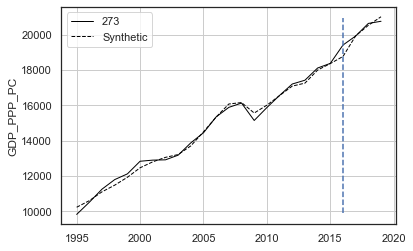

COBYLA


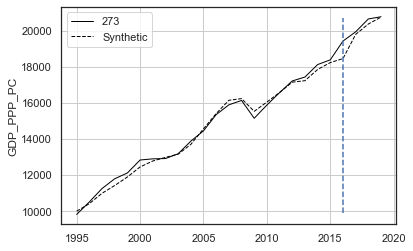

In [291]:
#################################################################################
# PARAMETERS
#################################################################################

# dep = "FISCAL_BAL_GDP"
# dep = "PRIM_BAL_GDP" # -> OK
dep = "GDP_PPP_PC"  # - >OK
# dep = "FCURR_DEBT" # -> OK
# dep = "INTR_EXPENSES_GDP" # -> OK
# dep = "CPI"
# dep = "EXR_INDEX" # ->OK

if dep == "CPI":
    d = d[d.WEO_CODE!=223]
    d = d[d.WEO_CODE!=248]


# predictors_dp       = ["DEBT_GDP"]
predictors_dp       = [dep]
dependent_dp        = dep
id_variable         = "WEO_CODE"
time_variable       = "DATE"

# special_predictors = None

special_predictors  = [("REV_GDP", range(year_t0,year_t1), "mean"),
                           ("TRADE_OPEN", range(year_t0,year_t1), "mean"),
                            ("NET_FDI_GDP", range(year_t0,year_t1), "mean"),
                            ("LUR", range(year_t0,year_t1), "mean"),
                            ("CAP_RETURN", range(year_t0,year_t1), "mean"),
                            ("INFLATION", range(year_t0,year_t1), "mean")]


treated             = code_treated 
controls            = list(set(d['WEO_CODE'].unique()) - set([treated]))
time_predictors     = range(year_t0,year_t1)
time_ssr            = range(year_t0,year_t1)

#################################################################################
# DATA PREPARATION
#################################################################################


dataprep = Dataprep(
           foo = d,
           predictors    = predictors_dp,
           predictors_op="mean",
           dependent     = dependent_dp,
           unit_variable = id_variable,
           time_variable = time_variable,
           special_predictors = special_predictors,
           treatment_identifier = treated,
           controls_identifier = controls,
           time_predictors_prior = time_predictors,
           time_optimize_ssr = time_ssr)

#################################################################################
print(dataprep)
#################################################################################
A = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYLA", "trust-constr"]
A = ["Powell", "COBYLA"]
resultados = {}

for metodo in A:
    synth = Synth()
    synth.fit(dataprep=dataprep, optim_method=metodo, optim_initial="ols")
    print(metodo)
    synth.path_plot(time_period=range(year_t0, year_t2), treatment_time=year_t1)
    mae = synth.mae()
    mse = synth.mspe()
    resultados[metodo] = {'MAE': mae, 'MSE': mse}

metodo_optimo = min(resultados, key=lambda x: resultados[x]['MSE'])
synth.fit(dataprep=dataprep, optim_method=metodo_optimo, optim_initial="ols")

## Variables

In [286]:
# Crear un objeto ExcelWriter
os.makedirs(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}_DRIVERS/{dep}', exist_ok=True) 
tablas = pd.ExcelWriter(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}_DRIVERS/{dep}/Tablas.xlsx')

<ipython-input-286-07c71d7b7f66>:3: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  tablas = pd.ExcelWriter(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}_DRIVERS/{dep}/Tablas.xlsx')


In [287]:
variables = synth.summary().round(3)
variables.columns = ["Weight", pais, f"{pais} Synth", "Sample Mean"]
variables.to_excel(tablas, sheet_name='Variables')
variables

,Weight,MEX,MEX Synth,Sample Mean
FCURR_DEBT,0.895,0.316,0.317,0.555
special.1.REV_GDP,0.010,0.209,0.197,0.216
special.2.TRADE_OPEN,0.088,0.565,0.560,0.739
special.3.NET_FDI_GDP,0.000,-0.168,-0.160,-0.204
special.4.LUR,0.001,0.041,0.100,0.092
special.5.CAP_RETURN,0.006,0.129,0.137,0.141
special.6.INFLATION,0.000,0.094,0.076,0.072


## Countries

In [288]:
# UK
# Country	Weight
# 33	Australia	0.433
# 45	United States of America (the)	0.325
# 4	Netherlands (the)	0.23

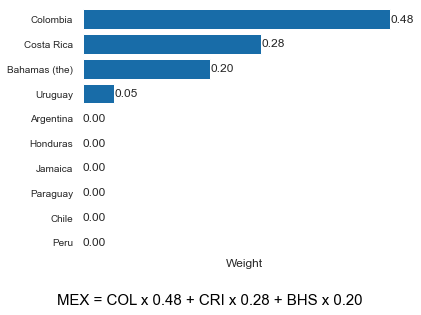

In [289]:
countries = d[["ISO3", "WEO_CODE", "COUNTRY_NAME"]].drop_duplicates()
countriesw = pd.DataFrame(zip(controls,synth.W)); countriesw.columns = ["WEO_CODE", "Weight"]
countries = countries.merge(countriesw, "right", "WEO_CODE")
countries = countries[["ISO3", "COUNTRY_NAME", "Weight"]]
countries.columns = ["ISO3", "Country", "Weight"]
countries = countries.sort_values(by = "Weight", ascending=False)
countries.to_excel(tablas, sheet_name='Countries')

filtered_countriesq = countries[countries['Weight'] > 0.1]
filtered_countries = countries.iloc[0:10]

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='Weight', y='Country', data=filtered_countries, color='#0070C0')
barplot.set_yticklabels(labels=filtered_countries['Country'], fontsize=10)
barplot.bar_label(barplot.containers[0], fmt='%.2f')
plt.xticks([])
plt.ylabel("")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
equation_parts = [f"{row['ISO3']} x {row['Weight']:.2f}" for index, row in filtered_countriesq.iterrows()]
equation_text = f"{tratado} = " + " + ".join(equation_parts)
plt.figtext(0.5, -0.08, equation_text, wrap=True, horizontalalignment='center', fontsize=15, color='black')
plt.tight_layout()
plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}_DRIVERS/{dep}/0COUNTRIES.jpg', dpi = 300, bbox_inches='tight')
plt.show()

## Effects

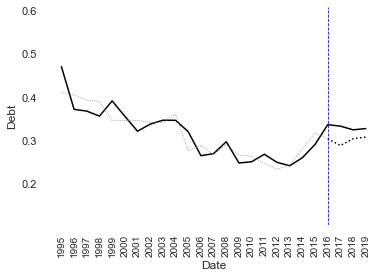

In [290]:
Z0, Z1   = dataprep.make_outcome_mats(time_period=range(year_t0, year_t2))
y_synth  = (Z0 * synth.W).sum(axis = 1)
y_actual = Z1
y_sample = Z0.T.mean()
effect    = y_actual - y_synth 
treat_year = fila = np.where(np.arange(year_t0, year_t2 + 1) == year_t1, 1, 0)
efecto = pd.DataFrame(zip(y_sample, y_actual, y_synth, effect, treat_year),
                      columns = ["Sample Mean", pais,f"{pais} Synth", "Effect", "Tyear"])
efecto.index = y_sample.index; efecto = efecto.reset_index(drop = False)
efecto.to_excel(tablas, sheet_name='Efecto')

# efecto = efecto[efecto.DATE>=2000]

plt.figure(figsize=(6, 4))
sns.set(style="white")
sns.lineplot(data=efecto, x='DATE', y=pais, color='black', label=None)
sns.lineplot(data=efecto[efecto['DATE'] <= year_t1], x='DATE', y=f'{pais} Synth',
             linestyle='dotted', color='gray', label=None, linewidth=0.8)
sns.lineplot(data=efecto[efecto['DATE'] >= year_t1], x='DATE', y=f'{pais} Synth',
             linestyle='dotted', color='black', label=None)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

minp = efecto[pais].min()
maxp = efecto[pais].max()
stdp = (efecto[pais].std()*2.5)
plt.ylim(minp-stdp,maxp+stdp)
# plt.yticks(np.arange(0, 0.6 + 0.05, 0.05))
plt.xlabel('Date')
plt.ylabel("Debt")
plt.axvline(x=year_t1, color='blue', linestyle='dashed', linewidth=0.8)
plt.xticks(efecto['DATE'], rotation=90, fontsize=10)

plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1}_{muestra}_DRIVERS/{dep}/1SYNTH.jpg', dpi = 300, bbox_inches='tight')

plt.show()

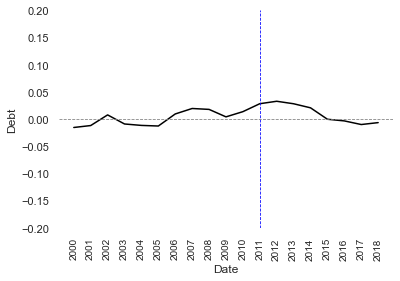

In [199]:
plt.figure(figsize=(6, 4))
sns.set(style="white")
sns.lineplot(data=efecto, x='DATE', y="Effect", color='black', label=None)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.ylim(-0.2,0.2)
plt.yticks(np.arange(-0.2, 0.2 + 0.05, 0.05))

# plt.ylim(-0.2,0.2)
# plt.yticks(np.arange(-0.2, 0.2 + 0.05, 0.05))

plt.xlabel('Date')
plt.ylabel("Debt")
plt.axvline(x=year_t1+1, color='blue', linestyle='dashed', linewidth=0.8)
plt.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.8)

plt.xticks(efecto['DATE'], rotation=90, fontsize=10)

plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1+1}_{muestra}_DRIVERS/{dep}/2EFFECT.jpg', dpi = 300, bbox_inches='tight')

plt.show()

In [ ]:
# pre = efecto[efecto.DATE<year_t1]["Effect"]; pre = np.sqrt((pre**2).sum()/len(pre))
# post = efecto[efecto.DATE>=year_t1]["Effect"]; post =  np.sqrt((post**2).sum()/len(post))
# post/pre

6.138960287475979

0.09738654447491805

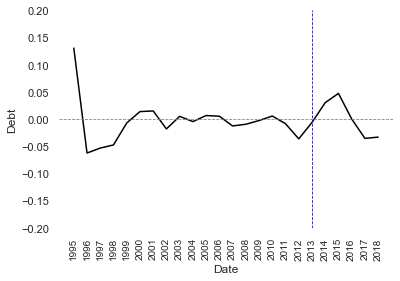

In [ ]:
plt.figure(figsize=(6, 4))
sns.set(style="white")
sns.lineplot(data=efecto, x='DATE', y="Effect", color='black', label=None)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.ylim(-0.2,0.2)
plt.yticks(np.arange(-0.2, 0.2 + 0.05, 0.05))

# plt.ylim(-0.2,0.2)
# plt.yticks(np.arange(-0.2, 0.2 + 0.05, 0.05))

plt.xlabel('Date')
plt.ylabel("Debt")
plt.axvline(x=year_t1+1, color='blue', linestyle='dashed', linewidth=0.8)
plt.axhline(y=0, color='gray', linestyle='dashed', linewidth=0.8)

plt.xticks(efecto['DATE'], rotation=90, fontsize=10)

plt.savefig(f'OUTPUT_{tratado}/{pais}_{year_t1+1}_{muestra}/2EFFECT.jpg', dpi = 300, bbox_inches='tight')

plt.show()

In [ ]:
# pre = efecto[efecto.DATE<year_t1]["Effect"]; pre = np.sqrt((pre**2).sum()/len(pre))
# post = efecto[efecto.DATE>=year_t1]["Effect"]; post =  np.sqrt((post**2).sum()/len(post))
# post/pre

6.138960287475979